# Devoir 7 ENE8220 Consommation Énergétique Industrielle


## Introduction
Le devoir a pour but d'introduire les étudiants à l'utilisation d'énergie dans un contexte industriel. Le devoir porte sur des notions de productivité énergétique et incite les étudiants à penser à la manière dont les tarifs d'électricité peuvent changer les incitatifs dans un contexte industriel

# Importation des librairies pertinents
Commençons par importer les librairies pertinents

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

## Importation des données

Dans un premier temps, les données sont importées de fichier excel qui retranscrivent les données de l'énoncé. Les fichier ne sont pas reproduits sur github mais sont disponibles sur requete 

In [2]:
conso_path = 'assets/consommation_energetique.xlsx'
prod_path = 'assets/production.xlsx'

conso = pd.read_excel(conso_path,converters= {'date_debut': pd.to_datetime,'date_fin':pd.to_datetime}).sort_values(by='date_debut')
prod = pd.read_excel(prod_path,converters= {'mois_prod': pd.to_datetime}).sort_values(by='mois_prod')
print(conso.to_latex(index=False))
print(prod.to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
date_debut & date_fin & consommation_energie[kWh] & puissance_reelle[kW] & puissance_apparente[kVA] \\
\midrule
2023-09-01 00:00:00 & 2023-09-30 00:00:00 & 530000 & 1205 & 1325 \\
2023-10-01 00:00:00 & 2023-10-31 00:00:00 & 540000 & 1200 & 1330 \\
2023-11-01 00:00:00 & 2023-11-30 00:00:00 & 540000 & 1195 & 1330 \\
2023-12-01 00:00:00 & 2023-12-31 00:00:00 & 370000 & 1190 & 1320 \\
2024-01-01 00:00:00 & 2024-01-31 00:00:00 & 520000 & 1200 & 1310 \\
2024-02-01 00:00:00 & 2024-02-29 00:00:00 & 510000 & 1205 & 1315 \\
2024-03-01 00:00:00 & 2024-03-31 00:00:00 & 540000 & 1200 & 1325 \\
2024-04-01 00:00:00 & 2024-04-30 00:00:00 & 530000 & 1215 & 1335 \\
2024-05-01 00:00:00 & 2024-05-31 00:00:00 & 260000 & 605 & 655 \\
2024-06-01 00:00:00 & 2024-06-30 00:00:00 & 630000 & 1495 & 1650 \\
2024-07-01 00:00:00 & 2024-07-31 00:00:00 & 660000 & 1505 & 1625 \\
2024-08-01 00:00:00 & 2024-08-31 00:00:00 & 680000 & 1500 & 1665 \\
\bottomrule
\end{tabular}

\begin{tabular}

## Jointure production et consommation énergétique

En premier lieu on créé des colonnes pour pouvoir joindre les deux tables


In [3]:
def string_jointure_conso(ligne:pd.Series):
    ligne['date_jointure'] = f'{ligne['date_debut'].year}-{ligne['date_debut'].month:02.0f}'
    return ligne
def string_jointure_prod(ligne:pd.Series):
    ligne['date_jointure'] = f'{ligne['mois_prod'].year}-{ligne['mois_prod'].month:02.0f}'
    return ligne
conso=conso.apply(string_jointure_conso,axis=1)
prod = prod.apply(string_jointure_prod,axis=1)

On peut maintenant faire la jointure

In [4]:
conso_prod = pd.merge(conso,prod,on='date_jointure',how='left')

## Productivité énergétique et en puissance
On calcule la puissance et l'énergie requise par unité de production

In [5]:
conso_prod['productivite_energetique[kWh/unite]']=conso_prod['consommation_energie[kWh]']/conso_prod['prod[-]']
conso_prod['productivite_puissance[kW/unite]']=conso_prod['puissance_reelle[kW]']/conso_prod['prod[-]']

## Graphiques

Création de graphiques pour visualiser les données

<Axes: xlabel='date_jointure'>

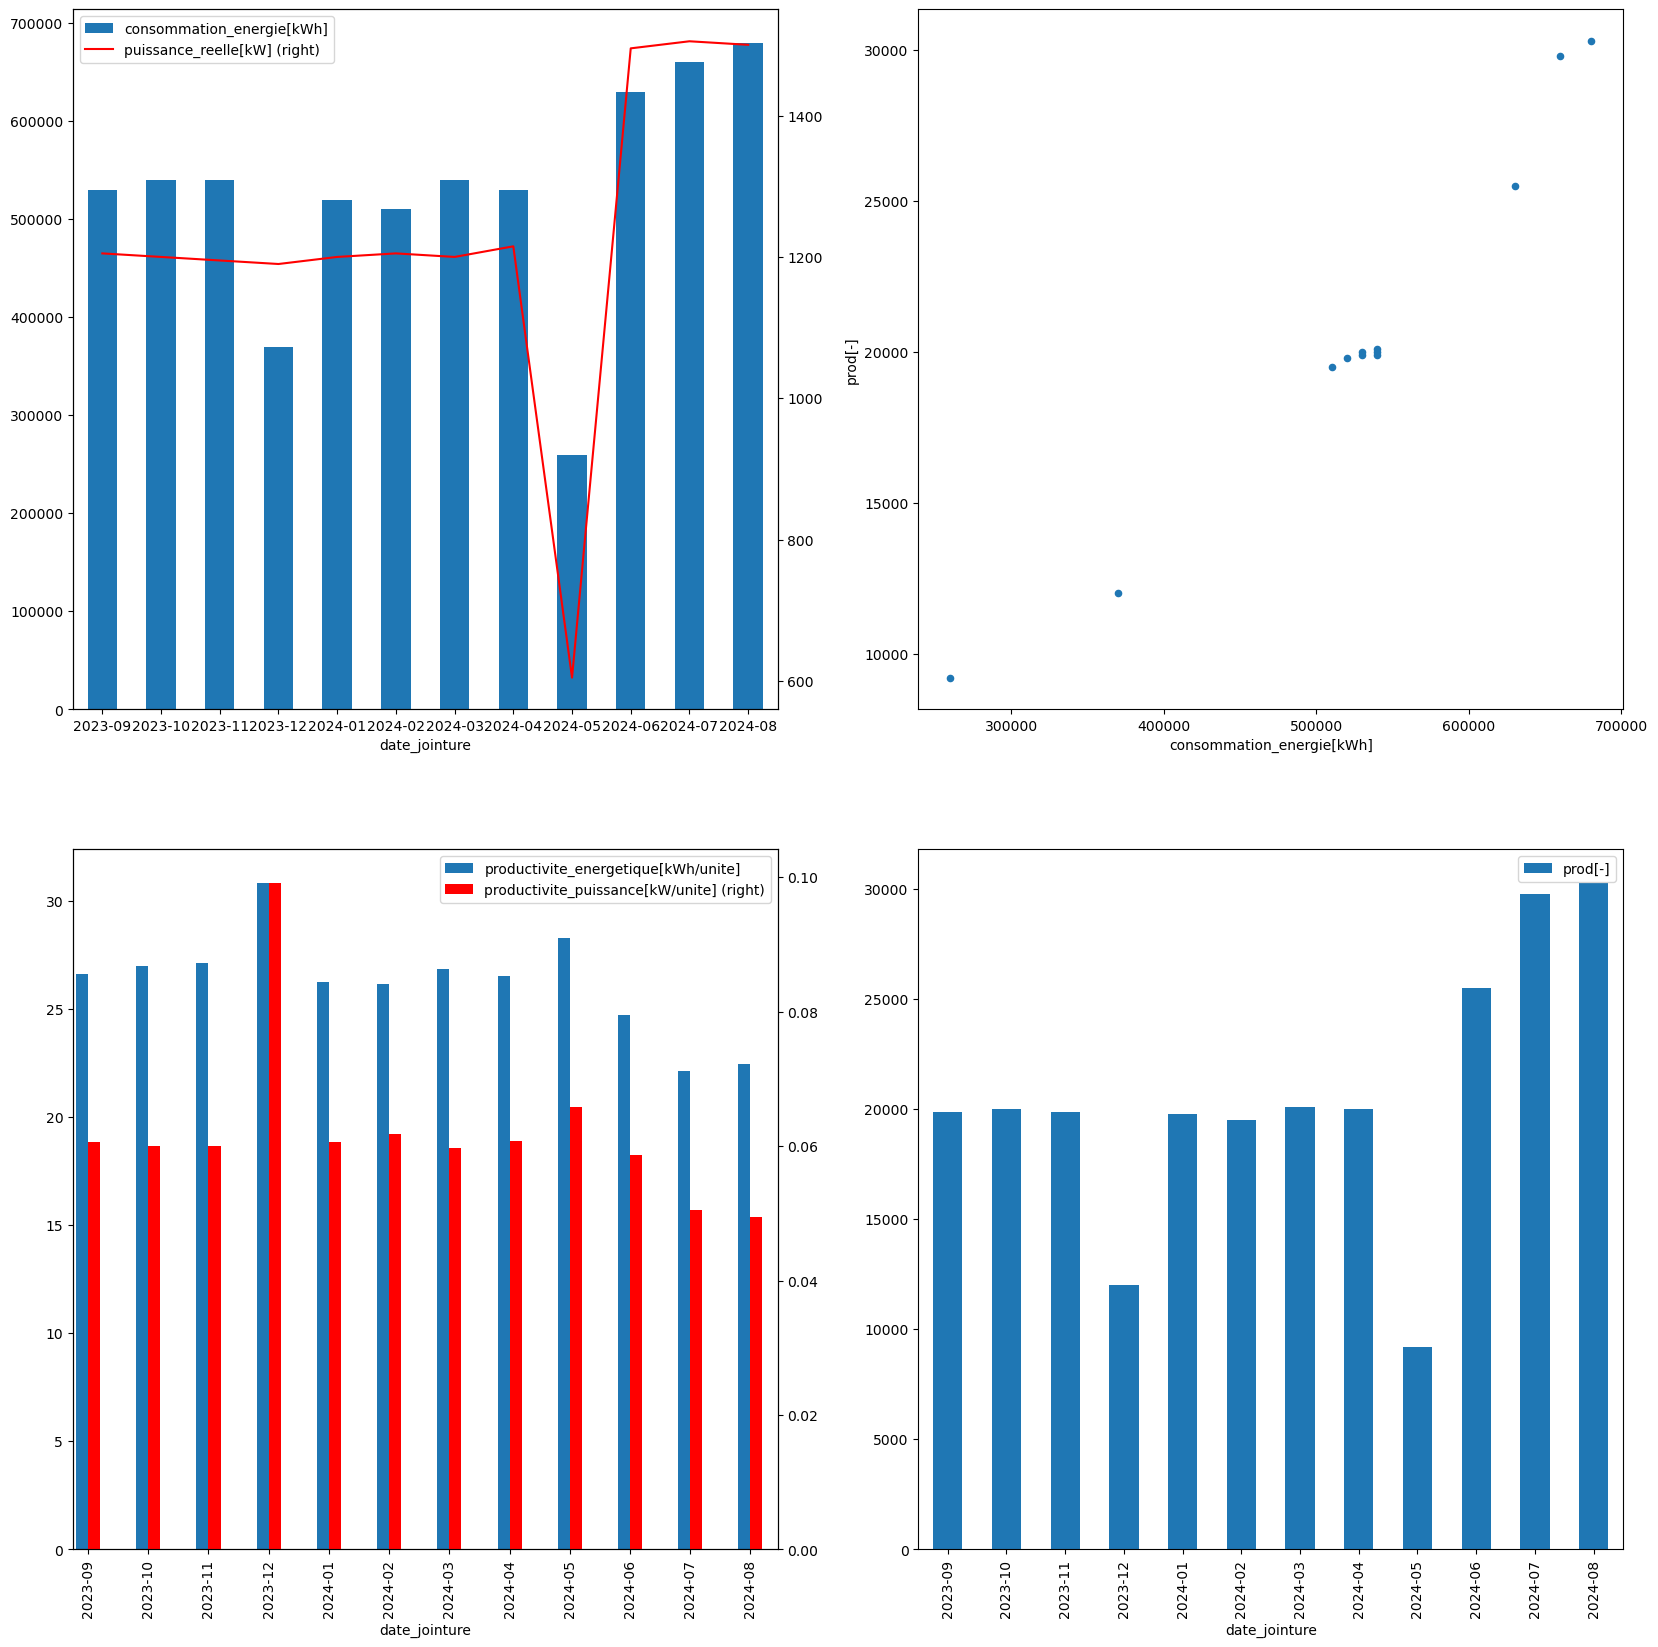

In [6]:
fig_expl,ax_expl = plt.subplots(nrows=2,ncols=2)
fig_expl.set_size_inches([20,20])
conso_prod.plot(kind='bar',x='date_jointure',y=['consommation_energie[kWh]'],ax=ax_expl[0,0])
conso_prod.plot(kind='line',x='date_jointure',y='puissance_reelle[kW]',secondary_y=True,ax=ax_expl[0,0],color='red')
conso_prod.plot(kind='scatter',ax=ax_expl[0,1],x='consommation_energie[kWh]',y='prod[-]')
conso_prod.plot(kind='bar',position=1,x='date_jointure',y='productivite_energetique[kWh/unite]',ax=ax_expl[1,0], width=0.2)
conso_prod.plot(kind='bar',position=0,x='date_jointure',y='productivite_puissance[kW/unite]',ax=ax_expl[1,0],color='red',secondary_y=True, width=0.2)
conso_prod.plot(kind='bar',x='date_jointure',y='prod[-]',ax=ax_expl[1,1])

## Calcul des couts en énergie
On va chercher les données tarifairs sur le [site d'Hydro-Québec](https://www.hydroquebec.com/data/documents-donnees/pdf/tarifs-electricite.pdf?v=20240522). \
Le tarif M est décrit de la manière suivante sur le site d'hydro Québec:\
| Composante    | Cout          | Unité |
| ------------- | ------------- | ------|
| Appel de puissance | 16.962 |$ / kW |
| Énergie ≤210000 kWh | 5.871| ₵/kWh |
| Énergie ­> 210000 kWh |4.339 |₵/kWh |

**Table 1:** Sommaire de grille tarifaire M 

In [7]:
cout_appel_puissance = 16.962 # $/kW
cout_energie_basse_consommation = 5.851 #c/kWh
seuil_consommation_HL = 210000 # kWh
cout_energie_haute_consommation = 4.339 #c/kWh
puissance_max_2022_2023 = 1210 #kW

Dans notre cas tous les mois ont vus une consommation supérieure à 210 000 kWh {260 000, 680 000}. Il y a donc un cout fixe vis-à-vis de cette énergie. Toute la consommation au dela de ce seuil est au prix inférieur. Une puissance minimale est appliqueé de 65% du max des 12 derniers mois avant la période actuelle. La valeur de cette consommation maximale est de 1210 kW pour 2022 2023 donc on peut l'utiliser 

In [8]:
conso_prod.loc[(conso_prod['date_debut'].dt.month<=12) & (conso_prod['date_debut'].dt.year ==2023),'puissance_max_hivernale[kW]'] = puissance_max_2022_2023
conso_prod.loc[(conso_prod['date_debut'].dt.month<4) & (conso_prod['date_debut'].dt.year ==2024),'puissance_max_hivernale[kW]'] = puissance_max_2022_2023
conso_prod.loc[(conso_prod['date_debut'].dt.month>=4) & (conso_prod['date_debut'].dt.year ==2024),'puissance_max_hivernale[kW]'] = conso_prod.loc[conso_prod['date_debut'].dt.month.isin([12,1,2,3]),'puissance_reelle[kW]'].max()
conso_prod['puissance_minimale_a_facturer[kW]'] = conso_prod['puissance_max_hivernale[kW]']*0.65
conso_prod['facteur_puissance[-]']=conso_prod['puissance_reelle[kW]']/conso_prod['puissance_apparente[kVA]']
conso_prod['n_jours_periode'] = conso_prod['date_fin'].dt.dayofyear - conso_prod['date_debut'].dt.day_of_year + 1

Calcul des couts énergétiques au moyen d'une fonction apply qui fait les calculs

In [9]:
def calculate_energy_cost(ligne:pd.Series):
    if ligne['consommation_energie[kWh]']<=seuil_consommation_HL:
        ligne['cout_tarif_basse_consommation[$]'] = ligne['consommation_energie[kWh]'] * cout_energie_basse_consommation /100
        ligne['cout_tarif_haute_consommation[$]'] = 0
    else:
        ligne['cout_tarif_basse_consommation[$]'] = cout_energie_basse_consommation * seuil_consommation_HL /100
        ligne['cout_tarif_haute_consommation[$]'] = (ligne['consommation_energie[kWh]']-seuil_consommation_HL) * cout_energie_haute_consommation /100
    return ligne
conso_prod = conso_prod.apply(calculate_energy_cost,axis=1)


On doit ensuite faire des manipulation pour trouver le cout de facturation de la puissance. On trouve le max entre la puissance réellement appellé et la puissance minimale à facturer et on applique le prorata du nombre de jours pour la puissance appellée

In [10]:
def power_to_bill(ligne:pd.Series):
    # 
    ligne['puissance_a_facturer[kW]'] = max(ligne['puissance_reelle[kW]'],ligne['puissance_minimale_a_facturer[kW]'])
    ligne['cout_puissance[$]'] = ligne['puissance_a_facturer[kW]'] * ligne['n_jours_periode']/30 * cout_appel_puissance
    return ligne
conso_prod = conso_prod.apply(power_to_bill,axis=1)
conso_prod['cout_total_avant_taxes'] = conso_prod['cout_puissance[$]'] + conso_prod['cout_tarif_haute_consommation[$]']+conso_prod['cout_tarif_basse_consommation[$]']

Faisons une régression linéaire pour la consommation d'énergie avant et après

In [11]:
reg_avant = LinearRegression().fit(conso_prod.loc[((conso_prod["date_debut"].dt.month<=5) & (conso_prod['date_debut'].dt.year==2024)|(conso_prod['date_debut'].dt.year==2023)),'prod[-]'].to_numpy().reshape(-1, 1),conso_prod.loc[((conso_prod["date_debut"].dt.month<=5) & (conso_prod['date_debut'].dt.year==2024)|(conso_prod['date_debut'].dt.year==2023)),'consommation_energie[kWh]'].to_numpy().reshape(-1, 1))
x_reg = np.array([range(0,35000,1000)]).reshape(-1, 1)
pred_reg_avant = reg_avant.predict(x_reg)
reg_apres = LinearRegression().fit(conso_prod.loc[((conso_prod["date_debut"].dt.month>5) & (conso_prod['date_debut'].dt.year==2024)),'prod[-]'].to_numpy().reshape(-1, 1),conso_prod.loc[((conso_prod["date_debut"].dt.month>5) & (conso_prod['date_debut'].dt.year==2024)),'consommation_energie[kWh]'].to_numpy().reshape(-1, 1))
x_reg_apres = np.array([range(0,35000,1000)]).reshape(-1, 1)
pred_reg_apres = reg_apres.predict(x_reg)
print(reg_avant.score(conso_prod.loc[((conso_prod["date_debut"].dt.month<=5) & (conso_prod['date_debut'].dt.year==2024)|(conso_prod['date_debut'].dt.year==2023)),'prod[-]'].to_numpy().reshape(-1, 1),conso_prod.loc[((conso_prod["date_debut"].dt.month<=5) & (conso_prod['date_debut'].dt.year==2024)|(conso_prod['date_debut'].dt.year==2023)),'consommation_energie[kWh]'].to_numpy().reshape(-1, 1)))
print(reg_apres.score(conso_prod.loc[((conso_prod["date_debut"].dt.month>5) & (conso_prod['date_debut'].dt.year==2024)),'prod[-]'].to_numpy().reshape(-1, 1),conso_prod.loc[((conso_prod["date_debut"].dt.month>5) & (conso_prod['date_debut'].dt.year==2024)),'consommation_energie[kWh]'].to_numpy().reshape(-1, 1)))

0.9828381092529894
0.904745408278954


On calcule la puissance moyenne avant et après les travaux pour estimer la puissance max moyenne

In [12]:
puissance_avant_travaux = conso_prod.loc[((conso_prod['date_debut'].dt.year==2024)&(conso_prod['date_debut'].dt.month<5))|(conso_prod['date_debut'].dt.year==2023),'puissance_reelle[kW]'].mean()
puissance_apres_travaux = conso_prod.loc[((conso_prod['date_debut'].dt.year==2024)&(conso_prod['date_debut'].dt.month>=6)),'puissance_reelle[kW]'].mean()

On a maintenant fait le calcul pour l'ensemble des couts, on peut faire les graphiques

In [13]:
print(conso_prod[['date_jointure','n_jours_periode','puissance_minimale_a_facturer[kW]','puissance_a_facturer[kW]','puissance_reelle[kW]','puissance_a_facturer[kW]','cout_puissance[$]','cout_tarif_basse_consommation[$]','cout_tarif_haute_consommation[$]','cout_total_avant_taxes']].to_latex(index=False,float_format="{:.2f}".format))

\begin{tabular}{lrrrrrrrrr}
\toprule
date_jointure & n_jours_periode & puissance_minimale_a_facturer[kW] & puissance_a_facturer[kW] & puissance_reelle[kW] & puissance_a_facturer[kW] & cout_puissance[$] & cout_tarif_basse_consommation[$] & cout_tarif_haute_consommation[$] & cout_total_avant_taxes \\
\midrule
2023-09 & 30 & 786.50 & 1205.00 & 1205 & 1205.00 & 20439.21 & 12287.10 & 13884.80 & 46611.11 \\
2023-10 & 31 & 786.50 & 1200.00 & 1200 & 1200.00 & 21032.88 & 12287.10 & 14318.70 & 47638.68 \\
2023-11 & 30 & 786.50 & 1195.00 & 1195 & 1195.00 & 20269.59 & 12287.10 & 14318.70 & 46875.39 \\
2023-12 & 31 & 786.50 & 1190.00 & 1190 & 1190.00 & 20857.61 & 12287.10 & 6942.40 & 40087.11 \\
2024-01 & 31 & 786.50 & 1200.00 & 1200 & 1200.00 & 21032.88 & 12287.10 & 13450.90 & 46770.88 \\
2024-02 & 29 & 786.50 & 1205.00 & 1205 & 1205.00 & 19757.90 & 12287.10 & 13017.00 & 45062.00 \\
2024-03 & 31 & 786.50 & 1200.00 & 1200 & 1200.00 & 21032.88 & 12287.10 & 14318.70 & 47638.68 \\
2024-04 & 30 & 783.2

## Prévision pour le prochain mois

On peut maintent réutiliser la régression poru prévoir la demande énergétique en fonction de la production

In [14]:
projection_energie = reg_apres.predict(np.array([31000]).reshape(1, -1))
projection_puissance = puissance_apres_travaux
couts_puissance = projection_puissance * 30 / 30 * cout_appel_puissance
couts_bas_conso =  cout_energie_basse_consommation * seuil_consommation_HL /100
cout_haut_conso = (projection_energie[0,0] - seuil_consommation_HL) * cout_energie_haute_consommation/100
projection = pd.DataFrame(columns=['date_jointure','projection_prod','projection_energie','projection_puissance','projection_cout_puissance','projection_cout_basse_en','projection_cout_haute_en'],data=[['2024-09',31000,projection_energie[0][0],projection_puissance,couts_puissance,couts_bas_conso,cout_haut_conso]])
conso_prod = pd.concat([conso_prod,projection])

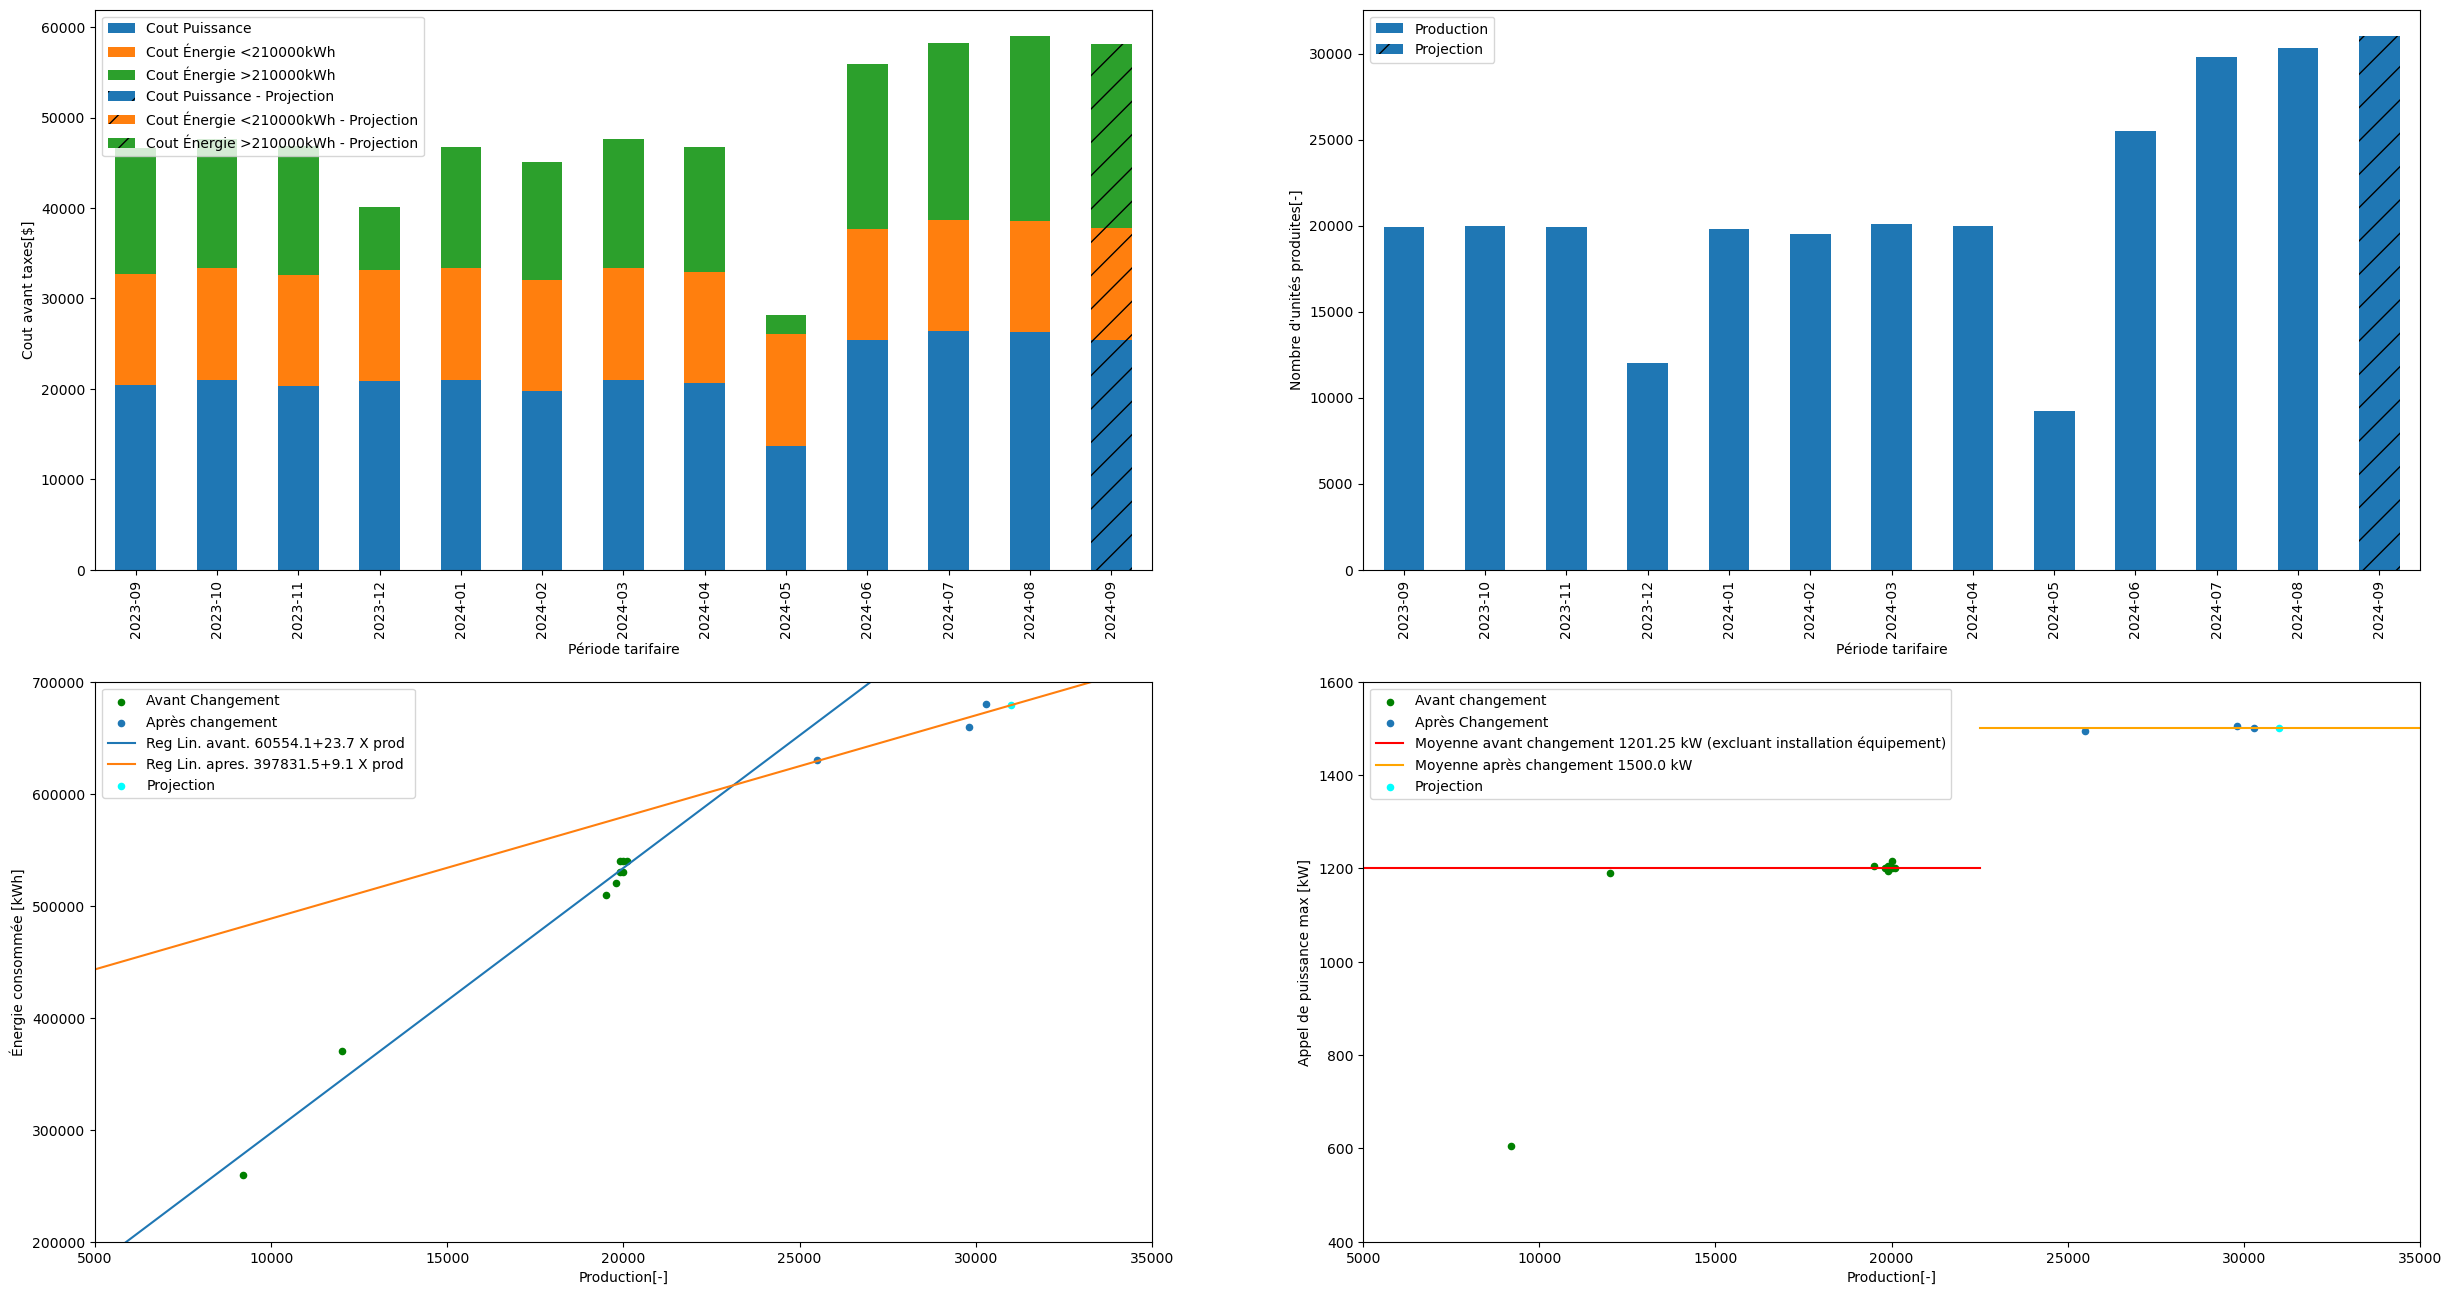

In [15]:
fig_tarif,ax_tarif = plt.subplots(nrows=2,ncols=2)
fig_tarif.set_size_inches([30,16])
# Graph haut gauche
conso_prod.plot(kind='bar',stacked=True,x='date_jointure',y=['cout_puissance[$]','cout_tarif_basse_consommation[$]','cout_tarif_haute_consommation[$]'],ax=ax_tarif[0,0],ylabel='Cout avant taxes[$]',xlabel='Période tarifaire')
conso_prod.plot(kind='bar',stacked=True, hatch='/',x='date_jointure',y=['projection_cout_puissance','projection_cout_basse_en','projection_cout_haute_en'],ax=ax_tarif[0,0],xlabel='Période tarifaire')
ax_tarif[0,0].legend(['Cout Puissance','Cout Énergie <210000kWh','Cout Énergie >210000kWh','Cout Puissance - Projection','Cout Énergie <210000kWh - Projection','Cout Énergie >210000kWh - Projection'])
# Graph haut droite
conso_prod.plot(kind='bar',stacked=True,x='date_jointure',y=['prod[-]'],ax=ax_tarif[0,1],ylabel="Nombre d'unités produites[-]")
conso_prod.plot(kind='bar',stacked=True, hatch='/',x='date_jointure',y='projection_prod',ax=ax_tarif[0,1],xlabel='Période tarifaire')
ax_tarif[0,1].legend(['Production','Projection'])
# Graph bas gauche
conso_prod.loc[((conso_prod["date_debut"].dt.month<=5) & (conso_prod['date_debut'].dt.year==2024)|(conso_prod['date_debut'].dt.year==2023)),['date_jointure','prod[-]','consommation_energie[kWh]']].plot(kind='scatter',x='prod[-]',y='consommation_energie[kWh]',xlabel='Production[-]',ylabel="Consommation d'énergie[kWh]",ax=ax_tarif[1,0],xlim=[7000,35000],ylim=[260000,700000],color='green')
conso_prod.loc[((conso_prod["date_debut"].dt.month>5) & (conso_prod['date_debut'].dt.year==2024)),['date_jointure','prod[-]','consommation_energie[kWh]']].plot(kind='scatter',x='prod[-]',y='consommation_energie[kWh]',xlabel='Production[-]',ylabel="Consommation d'énergie[kWh]",ax=ax_tarif[1,0],xlim=[5000,35000],ylim=[200000,700000])
ax_tarif[1,0].plot(x_reg,pred_reg_avant)
ax_tarif[1,0].plot(x_reg,pred_reg_apres)
conso_prod.plot(kind='scatter', color='cyan',x='projection_prod',y='projection_energie',ax=ax_tarif[1,0],xlabel='Production[-]',ylabel="Énergie consommée [kWh]")
ax_tarif[1,0].legend(['Avant Changement','Après changement',f'Reg Lin. avant. {reg_avant.intercept_[0]:.1f}+{reg_avant.coef_[0,0]:.1f} X prod ',f'Reg Lin. apres. {reg_apres.intercept_[0]:.1f}+{reg_apres.coef_[0,0]:.1f} X prod ','Projection'])
# graph bas droite
conso_prod.loc[((conso_prod["date_debut"].dt.month<=5) & (conso_prod['date_debut'].dt.year==2024)|(conso_prod['date_debut'].dt.year==2023)),['date_jointure','prod[-]','consommation_energie[kWh]','puissance_reelle[kW]']].plot(kind='scatter',x='prod[-]',y='puissance_reelle[kW]',xlabel='Production[-]',ylabel="Appel de puissance max [kW]",ax=ax_tarif[1,1],xlim=[5000,35000],ylim=[605,1600],color='green')
conso_prod.loc[((conso_prod["date_debut"].dt.month>5) & (conso_prod['date_debut'].dt.year==2024)),['date_jointure','prod[-]','consommation_energie[kWh]','puissance_reelle[kW]']].plot(kind='scatter',x='prod[-]',y='puissance_reelle[kW]',xlabel='Production[-]',ylabel="Appel de puissance max [kW]",ax=ax_tarif[1,1],xlim=[5000,35000],ylim=[400,1600])
ax_tarif[1,1].plot([5000,22500],[puissance_avant_travaux,puissance_avant_travaux],color='red')
ax_tarif[1,1].plot([22500,35000],[puissance_apres_travaux,puissance_apres_travaux],color='orange')

conso_prod.plot(kind='scatter', color='cyan',x='projection_prod',y='projection_puissance',ax=ax_tarif[1,1],xlabel='Production[-]',ylabel="Appel de puissance max [kW]")
plt.legend(['Avant changement','Après Changement',f'Moyenne avant changement {puissance_avant_travaux} kW (excluant installation équipement)',f'Moyenne après changement {puissance_apres_travaux} kW','Projection'])